# 1. Setup

In [ ]:
!pip install gym_super_mario_bros==7.3.0 nes_py

In [1]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [3]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [2]:
# Setup game
env = gym_super_mario_bros.make("SuperMarioBros-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT) # wrap to down sample actions from 256 -> 7

In [5]:
env.action_space

Discrete(7)

In [6]:
env.observation_space.shape # image

(240, 256, 3)

In [ ]:
done = True
for step in range(100000):
    if done:
        env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()
env.close()

# 2. Preprocess Environment

In [3]:
# Import frame stacker wrapper and grayscaling wrapper
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

In [14]:
# 1. Create the base environment
env = gym_super_mario_bros.make("SuperMarioBros-v0")
# 2. Simplify the controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last') # stack 4 frames

In [23]:
state = env.reset()

In [16]:
state.shape

(1, 240, 256, 4)

In [29]:
state, reward, done, info = env.step([env.action_space.sample()])

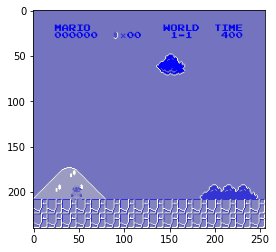

In [21]:
plt.imshow(state[0])

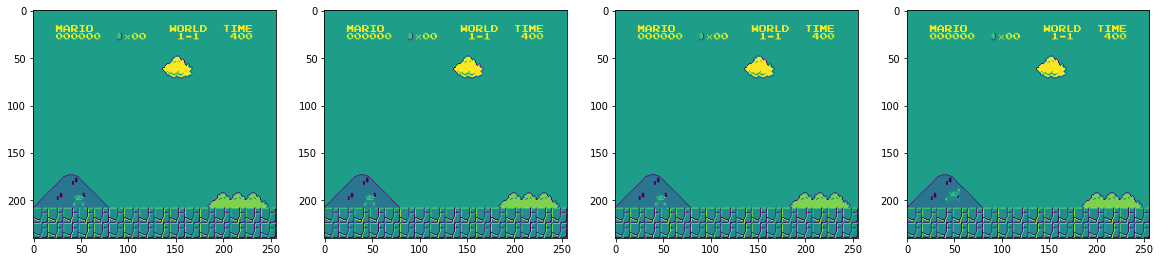

In [31]:
# Visualize frame stack
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

# 3. Train the RL Model

In [32]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [33]:
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [34]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [35]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000,save_path=CHECKPOINT_DIR)

In [36]:
model = PPO('CnnPolicy',env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001,n_steps=512)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [ ]:
# Train the AI
model.learn(total_timesteps=1000000, callback=callback)

# 4. Test it Out

In [38]:
model = PPO.load('./train/best_model_1000000')

In [ ]:
state = env.reset()
while True:
    action, _state = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

In [40]:
env.close()